In [1]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.lw.info

import rtmtools.rrtmg.lw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.lw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)

<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [2]:
name_molecule = r'$H_{2}O$'

#### Load CRD results

In [167]:
# Get lbl line-by-line results
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H2008_h2O_cut25/OUTPUT_RADSUM'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, cooling_rate = True, signed_fluxes = True)


In [13]:
# H1996 cutoff = 10 cm-1
pathout_crd1 = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H1996_H2O_cut10/OUTPUT_RADSUM'
pnl_crd1 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd1, cooling_rate = True, signed_fluxes = True)


#### Load CLIRAD results

In [126]:
# Read OUTPUT_CLIRAD.dat
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_H2012/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, cooling_rate = True, signed_fluxes= True)


In [124]:
pathout_clirad_96 = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O/OUTPUT_CLIRAD.dat'
pnl_clirad_96 = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad_96, cooling_rate = True, signed_fluxes= True)

In [15]:
# prepare results Hitran 2012 updated version
def path_cliradlw_h2012():
    return '../clirad/LW/examples/mls75_H2O_H2012/CLIRAD_IR_output.dat'


def get_rateT(df, ratename = 'cooling rates'):
    return pd.DataFrame({'pressure': .5 * (df['p'].values[1:] + df['p'].values[: -1]),
                    ratename: df[ratename].values[1:]})


df = cliradwrangle.output_txtfile_to_DataFrame(path_cliradlw_h2012())

rateT_clirad2012 = get_rateT(df, ratename = 'cooling rates')

#### Load LBLRTM results

In [141]:
# Get AER line-by-line results
pathout_lblrtm = '/nuwa_cluster/home/jackyu/line_by_line/aerlbl_v12.2_package/runs/LW/run_mls75pro_H2O/OUTPUT_RADSUM'
pnl_lblrtm = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_lblrtm, signed_fluxes = True, cooling_rate = True)



#### Load RRTMG results

In [5]:
# load results for no continuum

fpath = os.path.join('/nuwa_cluster/home/jackyu/radiation/',
                     'rrtmg/LW/examples/mls70_H2O/OUTPUT_RRTM')

pnl_rrtmg = rrtmgwrangle\
.OUTPUT_RRTM_to_pandasPanel(readfrom=fpath, 
                            signed_fluxes = True, cooling_rate = True)

In [7]:
# load results for when there is continuum

fpath = os.path.join('/nuwa_cluster/home/jackyu/radiation/',
                     'rrtmg/LW/examples/mls70_H2O_cont/OUTPUT_RRTM')

pnl_rrtmg_cont = rrtmgwrangle\
.OUTPUT_RRTM_to_pandasPanel(readfrom=fpath,
                            signed_fluxes=True, cooling_rate=True)

# Total cooling rates

In [13]:
def plot_total_cooling_rates(infos_wavenumber=None, 
                             infos_spectralband=None):
    global molecule_name, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    if infos_wavenumber:
        (names_wavenumber, 
         colours_wavenumber, 
         linestyles_wavenumber, 
         pnls_wavenumber) = map(list, zip(*infos_wavenumber))
    
        dfs_wavenumber = [aeranalyse.\
                          sum_OUTPUT_RADSUM_over_wbands(pnl, 
                                                        V1=0, V2=3000)
                          for pnl in pnls_wavenumber]
    else:
        (dfs_wavenumber, names_wavenumber,
         colours_wavenumber, linestyles_wavenumber) = ([], [], [], [])
    
    if infos_spectralband:
        (names_spectralband, 
         colours_spectralband, 
         linestyles_spectralband, 
         pnls_spectralband) = map(list, zip(*infos_spectralband))
        
        dfs_spectralband = [cliradanalyse.
                            sum_OUTPUT_CLIRAD_over_wbands(pnl, 
                                                          wbands=range(1, 11))\
                            for pnl in pnls_spectralband]
    else:
        (dfs_spectralband, 
         names_spectralband,
         colours_spectralband,
         linestyles_spectralband) = ([], [], [], [])
        
    dfs = dfs_wavenumber + dfs_spectralband
    names = names_wavenumber + names_spectralband
    colours = colours_wavenumber + colours_spectralband
    linestyles = linestyles_wavenumber + linestyles_spectralband    
    
    dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
    
    viz.tabulate_difference(dfs=dfs_atm_levels, 
                            names=names,
                            title='Total cooling rate. {}'\
                            .format(name_molecule))    
    
    max_cr = max([df['cooling_rate'].max() for df in dfs])
    
    viz.plot_pres_vs_hrcr(dfs=dfs_wavenumber + dfs_spectralband,
                          names=names_wavenumber + names_spectralband,
                          linestyles=(linestyles_wavenumber 
                                      + linestyles_spectralband), 
                          colours=(colours_wavenumber 
                                   + colours_spectralband),
                          title='Total cooling rate. {}'\
                                .format(name_molecule),
                          cooling_rate=True,
                          xlim_linear=False,
                          xlim_log=(-.1, 20) if max_cr >= 20 else None)
    
    display.display(plt.gcf()); plt.close()
    


Total cooling rate. $H_{2}O$

cont
      pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -323.8965     0.0000 -323.8965       0.00000
30   299.70000 -329.2668    33.6985 -295.5683       2.16239
0   1013.00000 -423.5981   332.6542  -90.9439       3.23869

no cont
      pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -334.2143     0.0000 -334.2143       0.00000
30   299.70000 -339.1301    31.1483 -307.9818       2.08088
0   1013.00000 -423.5981   275.0453 -148.5528       1.87119

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0  10.3178     0.0000   10.3178       0.00000
30         0   9.8633     2.5502   12.4135       0.08151
0          0   0.0000    57.6089   57.6089       1.36750



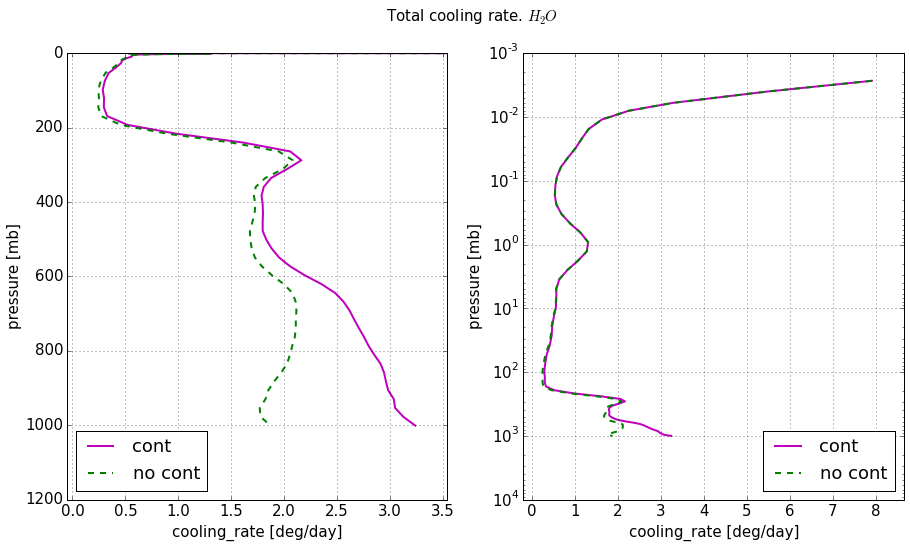

In [14]:
plot_total_cooling_rates(
    infos_wavenumber=[('cont', 'm', '-', pnl_rrtmg_cont),
                      ('no cont', 'g', '--', pnl_rrtmg)])

# In RRTMG's wavenumber bands

In [21]:

def fluxtableNhrplot_by_rrtmg_bands(infos_rrtmg=None, infos_lbl=None):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    if infos_lbl:
        (names_lbl, 
         colours_lbl, 
         linestyles_lbl, 
         pnls_lbl) = map(list, zip(*infos_lbl))
        pnls_lbl = [aeranalyse
                    .lines2bands(pnl_lbl, wbands = pnl_rrtmg.items.values)
                    for pnl_lbl in pnls_lbl]
    else:
        (names_lbl, colours_lbl, linestyles_lbl, pnls_lbl) = ([], [], [], [])
        
    if infos_rrtmg:
        (names_rrtmg,
         colours_rrtmg,
         linestyles_rrtmg,
         pnls_rrtmg) = map(list, zip(*infos_rrtmg))
    else:
        (names_rrtmg, 
         colours_rrtmg, 
         linestyles_rrtmg,
         pnls_rrtmg) = ([], [], [], [])
        
    names = names_rrtmg + names_lbl
    colours = colours_rrtmg + colours_lbl
    linestyles = linestyles_rrtmg + linestyles_lbl
    pnls = pnls_rrtmg + pnls_lbl
    
    
    for item in pnls[0].items:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs=dfs, 
                                names=names,
                                title=('RRTMG Wavenumber band: {} ~ {} cm-1'.format(*item)))      
        
        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['cooling_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate=True,
                              xlim_linear=None,
                              xlim_log=(- .5, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()
    


Flux tables and cooling rates in RRTMG spectral bands


---------------------------------------------------------------------------


RRTMG Wavenumber band: 10.0 ~ 350.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -35.7025     0.0000  -35.7025      -0.00000
30   299.70000 -38.4254    24.5201  -13.9053       1.40265
0   1013.00000 -54.5825    54.5792   -0.0033       0.00140

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -36.3061     0.0000  -36.3061      -0.00000
30   299.70000 -38.7258    22.3568  -16.3690       1.36489
0   1013.00000 -54.5825    54.5778   -0.0047       0.00201

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.6036     0.0000    0.6036       0.00000
30         0   0.3004     2.1633    2.4637       0.03776
0          0   0.0000     0.0014    0.0014      -0.00061



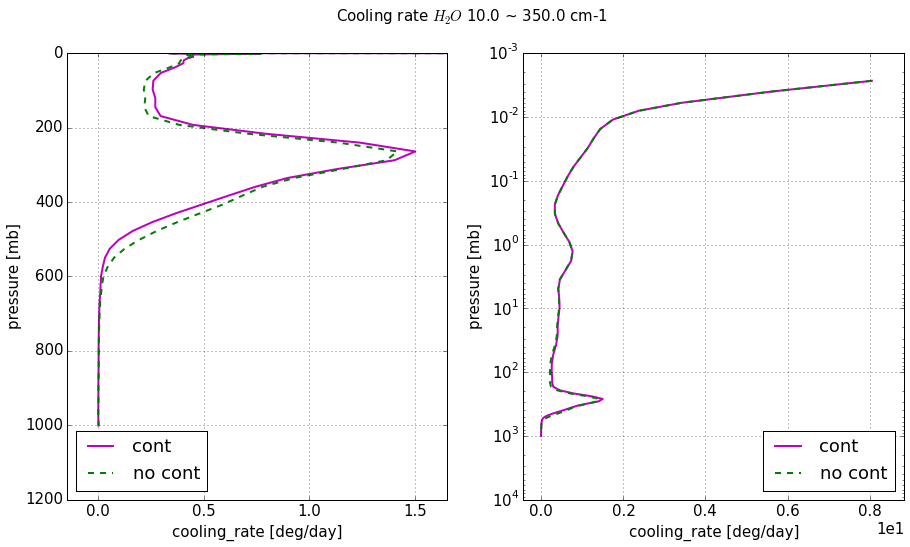

---------------------------------------------------------------------------


RRTMG Wavenumber band: 350.0 ~ 500.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -43.1126     0.0000  -43.1126      -0.00000
30   299.70000 -44.0132     5.5195  -38.4937       0.50015
0   1013.00000 -60.9174    60.8457   -0.0717       0.02865

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -44.3208     0.0000  -44.3208      -0.00000
30   299.70000 -45.1535     5.2688  -39.8847       0.46769
0   1013.00000 -60.9174    60.7515   -0.1659       0.05173

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   1.2082     0.0000    1.2082       0.00000
30         0   1.1403     0.2507    1.3910       0.03246
0          0   0.0000     0.0942    0.0942      -0.02308



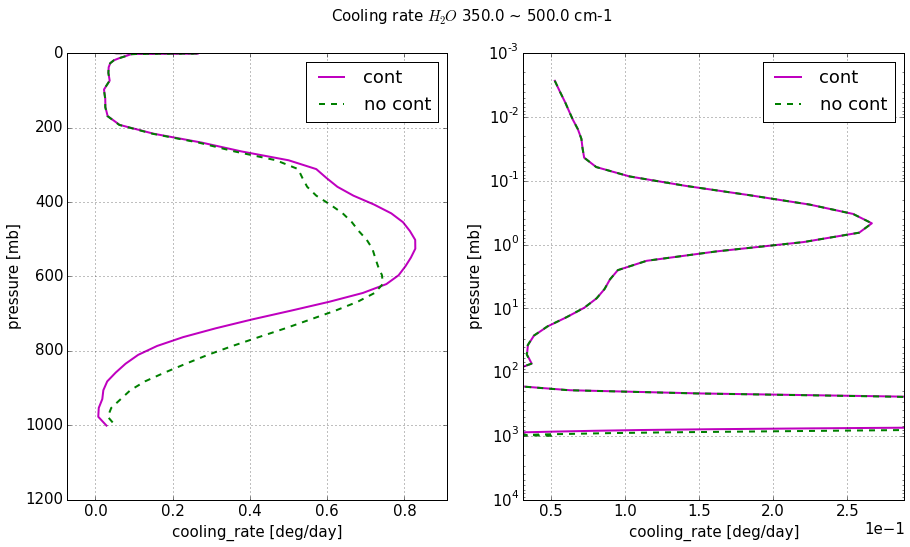

---------------------------------------------------------------------------


RRTMG Wavenumber band: 500.0 ~ 630.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -45.0435     0.0000  -45.0435      -0.00000
30   299.70000 -45.3933     1.2426  -44.1507       0.12307
0   1013.00000 -58.6463    58.1939   -0.4524       0.12731

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -47.0755     0.0000  -47.0755      -0.00000
30   299.70000 -47.3985     1.1975  -46.2010       0.11909
0   1013.00000 -58.6463    54.0152   -4.6311       0.40161

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   2.0320     0.0000    2.0320       0.00000
30         0   2.0052     0.0451    2.0503       0.00398
0          0   0.0000     4.1787    4.1787      -0.27430



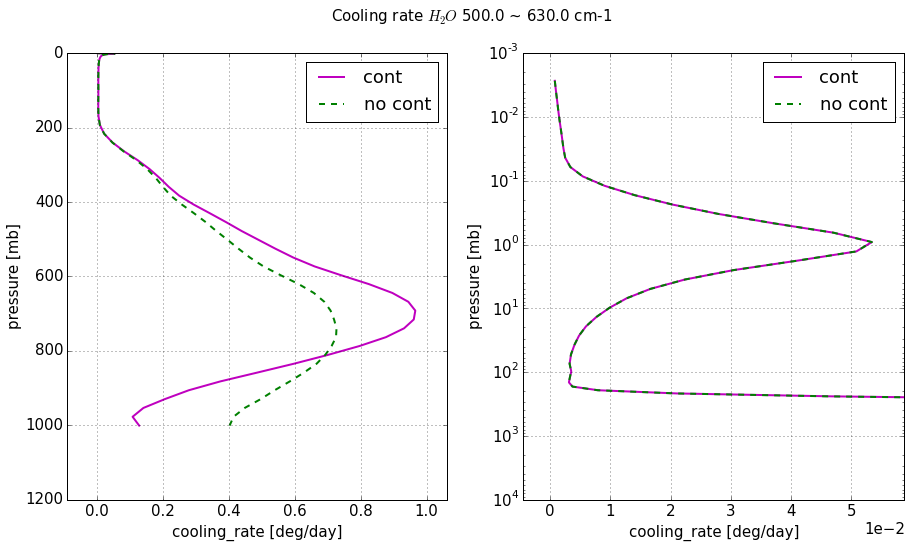

---------------------------------------------------------------------------


RRTMG Wavenumber band: 630.0 ~ 700.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -25.8597     0.0000  -25.8597      -0.00000
30   299.70000 -25.9260     0.1660  -25.7600       0.01814
0   1013.00000 -30.8951    28.9208   -1.9743       0.29469

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -27.1021     0.0000  -27.1021      -0.00000
30   299.70000 -27.1641     0.1609  -27.0032       0.01793
0   1013.00000 -30.8951    20.5885  -10.3066       0.31701

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   1.2424     0.0000    1.2424       0.00000
30         0   1.2381     0.0051    1.2432       0.00021
0          0   0.0000     8.3323    8.3323      -0.02232



/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.0, right=0.0
  'left=%s, right=%s') % (left, right))


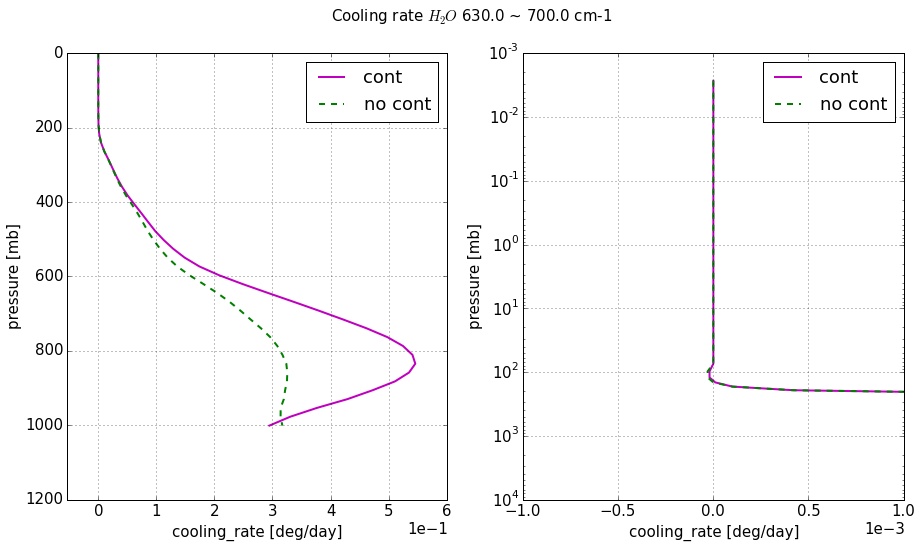

---------------------------------------------------------------------------


RRTMG Wavenumber band: 700.0 ~ 820.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -44.2957     0.0000  -44.2957      -0.00000
30   299.70000 -44.3277     0.0502  -44.2775       0.00448
0   1013.00000 -48.8867    34.3525  -14.5342       0.87654

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -46.0020     0.0000  -46.0020      -0.00000
30   299.70000 -46.0326     0.0487  -45.9839       0.00448
0   1013.00000 -48.8867    17.0901  -31.7966       0.38616

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   1.7063     0.0000    1.7063       0.00000
30         0   1.7049     0.0015    1.7064       0.00000
0          0   0.0000    17.2624   17.2624       0.49038



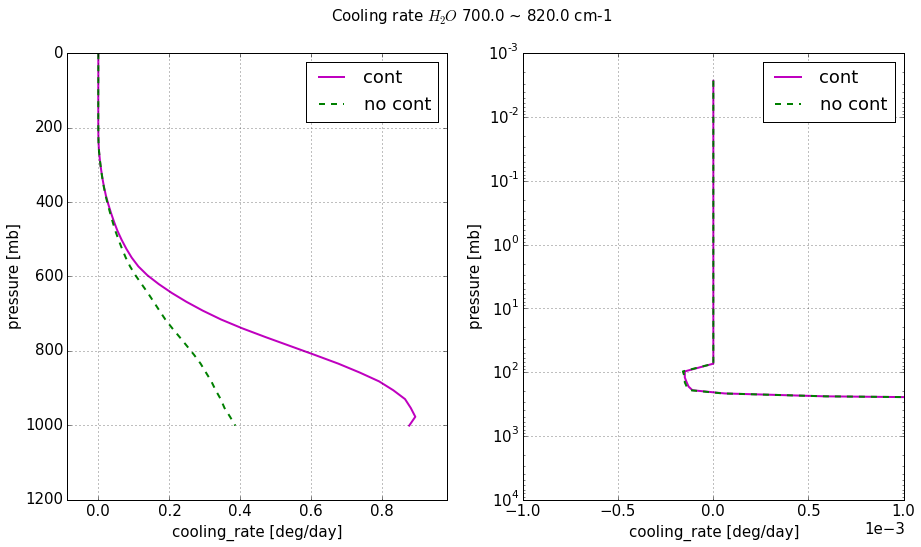

---------------------------------------------------------------------------


RRTMG Wavenumber band: 820.0 ~ 980.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -51.4027     0.0000  -51.4027      -0.00000
30   299.70000 -51.4093     0.0042  -51.4051      -0.00031
0   1013.00000 -53.9607    23.6088  -30.3519       0.94036

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -53.0264     0.0000  -53.0264      -0.00000
30   299.70000 -53.0324     0.0038  -53.0286      -0.00025
0   1013.00000 -53.9607     6.1714  -47.7893       0.18999

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   1.6237     0.0000    1.6237       0.00000
30         0   1.6231     0.0004    1.6235      -0.00006
0          0   0.0000    17.4374   17.4374       0.75037



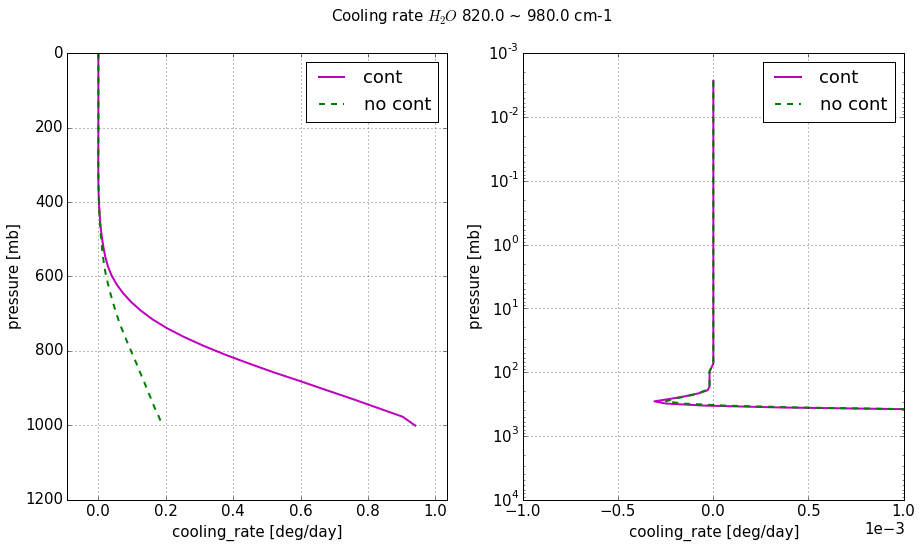

---------------------------------------------------------------------------


RRTMG Wavenumber band: 980.0 ~ 1080.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -25.7386     0.0000  -25.7386      -0.00000
30   299.70000 -25.7410     0.0011  -25.7399      -0.00020
0   1013.00000 -26.6402     7.6488  -18.9914       0.34081

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -26.2661     0.0000  -26.2661      -0.00000
30   299.70000 -26.2683     0.0010  -26.2673      -0.00018
0   1013.00000 -26.6402     2.2795  -24.3607       0.07521

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.5275     0.0000    0.5275       0.00000
30         0   0.5273     0.0001    0.5274      -0.00002
0          0   0.0000     5.3693    5.3693       0.26560



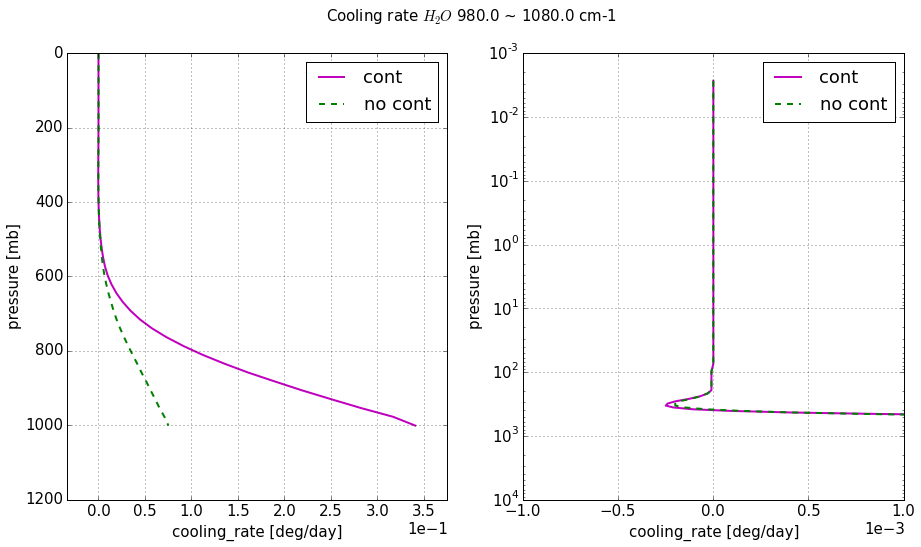

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1080.0 ~ 1180.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -20.2095     0.0000  -20.2095      -0.00000
30   299.70000 -20.2190     0.0066  -20.2124      -0.00014
0   1013.00000 -21.5225     7.3836  -14.1389       0.25967

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -20.5192     0.0000  -20.5192      -0.00000
30   299.70000 -20.5287     0.0066  -20.5221      -0.00014
0   1013.00000 -21.5225     4.5509  -16.9716       0.12243

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.3097     0.0000    0.3097       0.00000
30         0   0.3097     0.0000    0.3097       0.00000
0          0   0.0000     2.8327    2.8327       0.13724



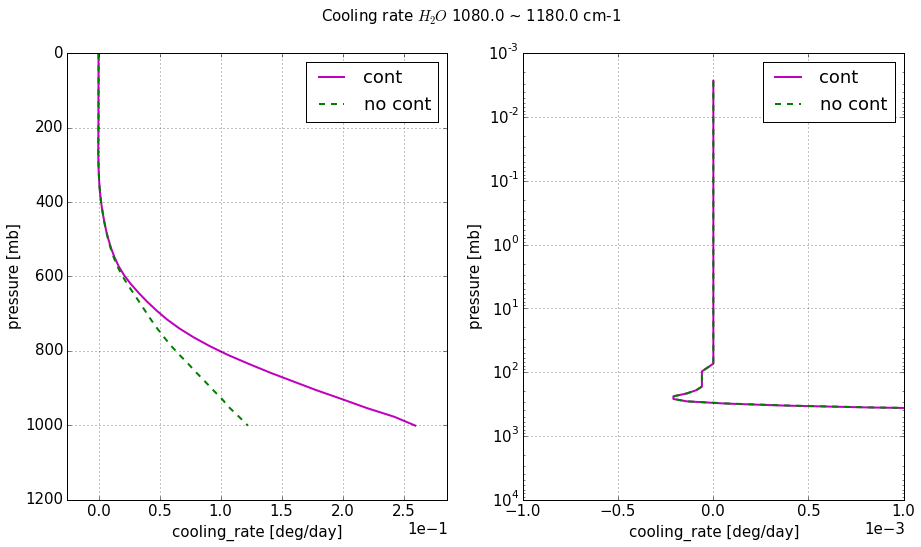

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1180.0 ~ 1390.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -21.5177     0.0000  -21.5177      -0.00000
30   299.70000 -21.7630     0.3147  -21.4483       0.01606
0   1013.00000 -31.2998    24.0055   -7.2943       0.29408

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -22.0664     0.0000  -22.0664      -0.00000
30   299.70000 -22.3024     0.3088  -21.9936       0.01648
0   1013.00000 -31.2998    22.2084   -9.0914       0.25038

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.5487     0.0000    0.5487       0.00000
30         0   0.5394     0.0059    0.5453      -0.00042
0          0   0.0000     1.7971    1.7971       0.04370



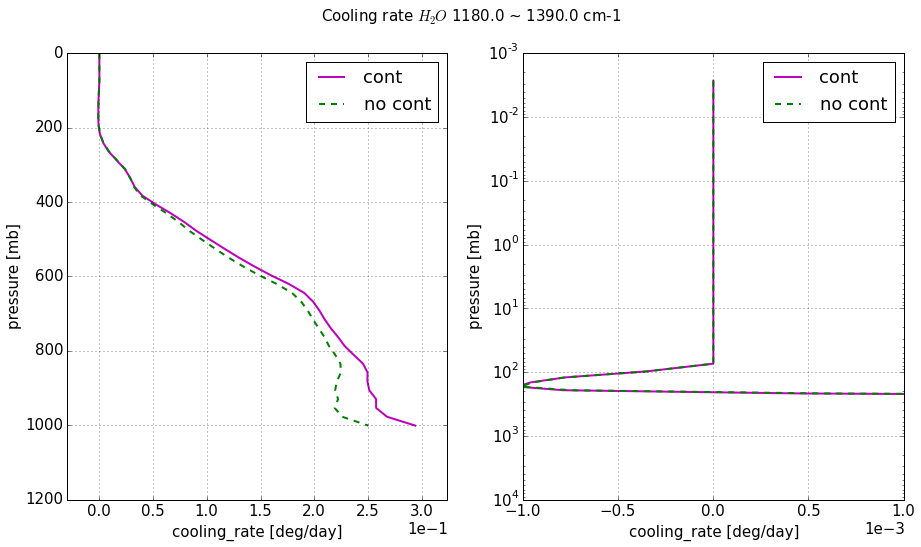

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1390.0 ~ 1480.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.3542     0.0000   -2.3542      -0.00000
30   299.70000  -2.6054     0.4857   -2.1197       0.02841
0   1013.00000  -8.8986     8.8893   -0.0093       0.00397

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.4808     0.0000   -2.4808      -0.00000
30   299.70000  -2.7200     0.4662   -2.2538       0.02661
0   1013.00000  -8.8986     8.8866   -0.0120       0.00512

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.1266     0.0000    0.1266       0.00000
30         0   0.1146     0.0195    0.1341       0.00180
0          0   0.0000     0.0027    0.0027      -0.00115



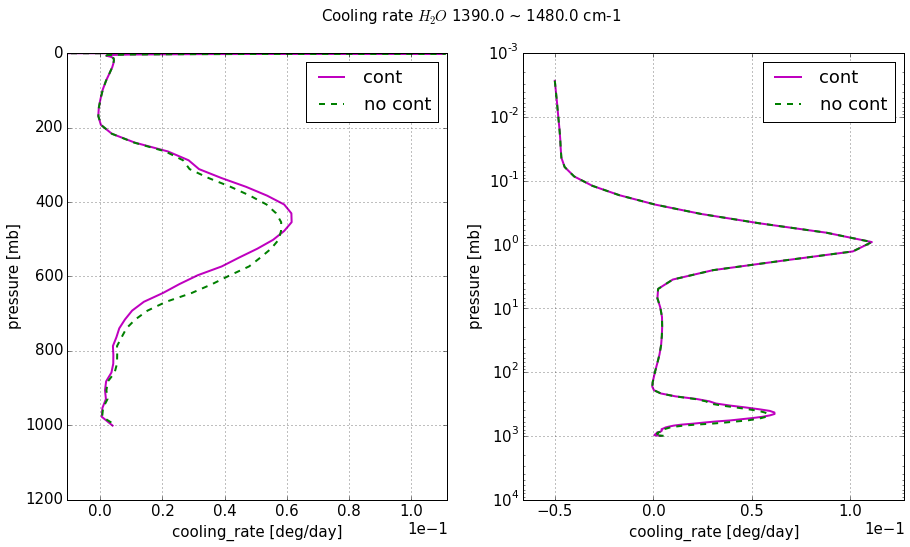

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1480.0 ~ 1800.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -3.0162     0.0000   -3.0162      -0.00000
30   299.70000  -3.7183     1.3225   -2.3958       0.07093
0   1013.00000 -17.8828    17.8732   -0.0096       0.00410

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -3.2226     0.0000   -3.2226      -0.00000
30   299.70000  -3.8991     1.2651   -2.6340       0.06488
0   1013.00000 -17.8828    17.8685   -0.0143       0.00607

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.2064     0.0000    0.2064       0.00000
30         0   0.1808     0.0574    0.2382       0.00605
0          0   0.0000     0.0047    0.0047      -0.00197



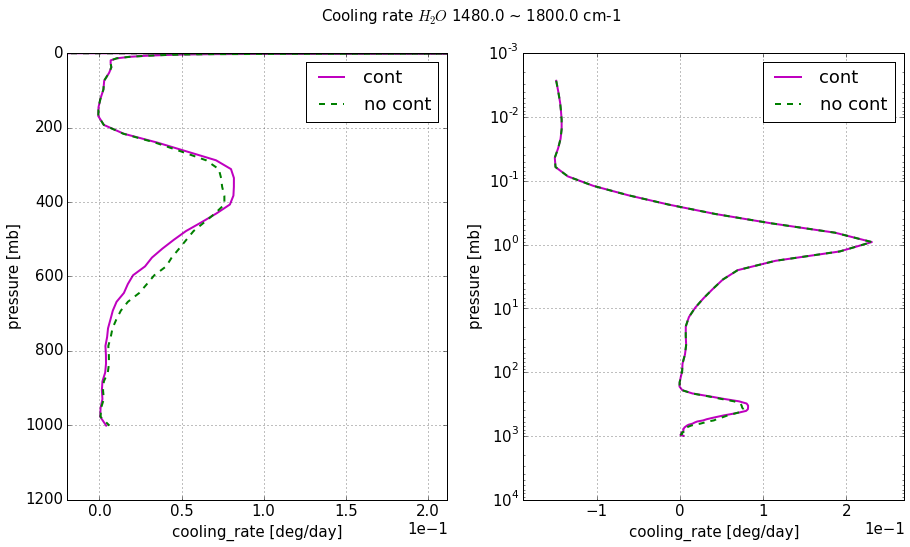

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1800.0 ~ 2080.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.6056     0.0000   -2.6056      -0.00000
30   299.70000  -2.6628     0.0642   -2.5986       0.00061
0   1013.00000  -5.9578     5.4473   -0.5105       0.04156

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.7629     0.0000   -2.7629      -0.00000
30   299.70000  -2.8171     0.0630   -2.7541       0.00084
0   1013.00000  -5.9578     5.2503   -0.7075       0.04283

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.1573     0.0000    0.1573       0.00000
30         0   0.1543     0.0012    0.1555      -0.00023
0          0   0.0000     0.1970    0.1970      -0.00127



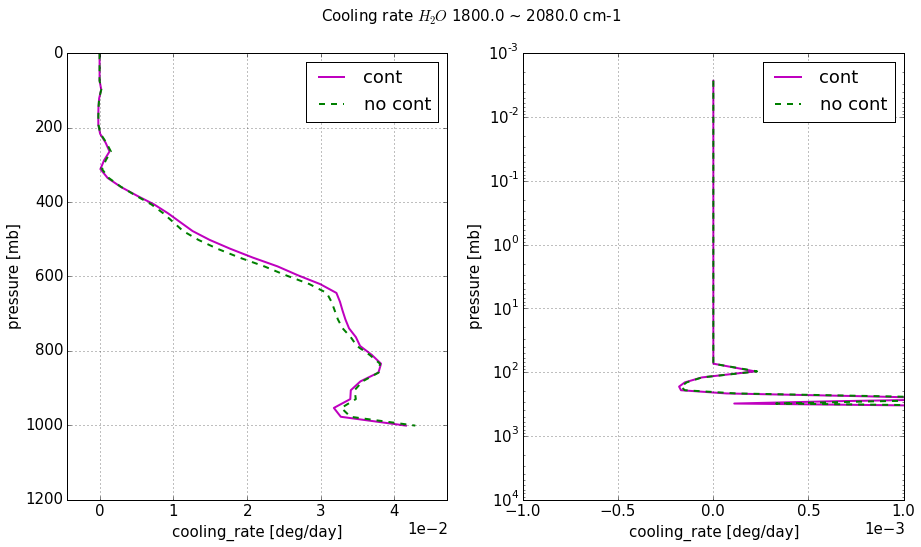

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2080.0 ~ 2250.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -1.4012     0.0000   -1.4012      -0.00000
30   299.70000  -1.4028     0.0002   -1.4026      -0.00022
0   1013.00000  -1.6390     0.6063   -1.0327       0.01773

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -1.4164     0.0000   -1.4164      -0.00000
30   299.70000  -1.4180     0.0002   -1.4178      -0.00021
0   1013.00000  -1.6390     0.5408   -1.0982       0.01455

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.0152     0.0000    0.0152       0.00000
30         0   0.0152     0.0000    0.0152      -0.00001
0          0   0.0000     0.0655    0.0655       0.00318



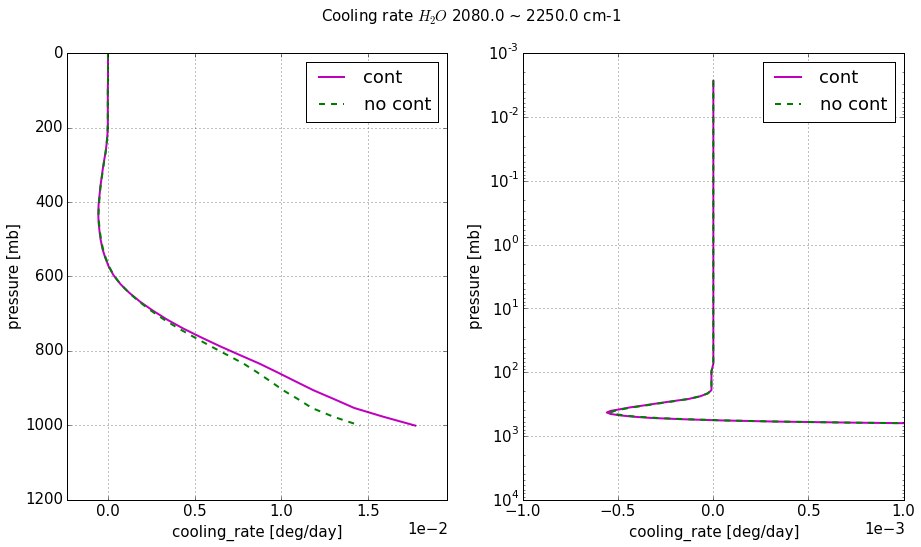

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2250.0 ~ 2380.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.7288      0.000   -0.7288      -0.00000
30   299.70000  -0.7288      0.000   -0.7288      -0.00000
0   1013.00000  -0.7316      0.013   -0.7186       0.00078

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.7315          0   -0.7315            -0
30   299.70000  -0.7315          0   -0.7315            -0
0   1013.00000  -0.7316          0   -0.7316            -0

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.0027      0.000    0.0027       0.00000
30         0   0.0027      0.000    0.0027       0.00000
0          0   0.0000      0.013    0.0130       0.00078



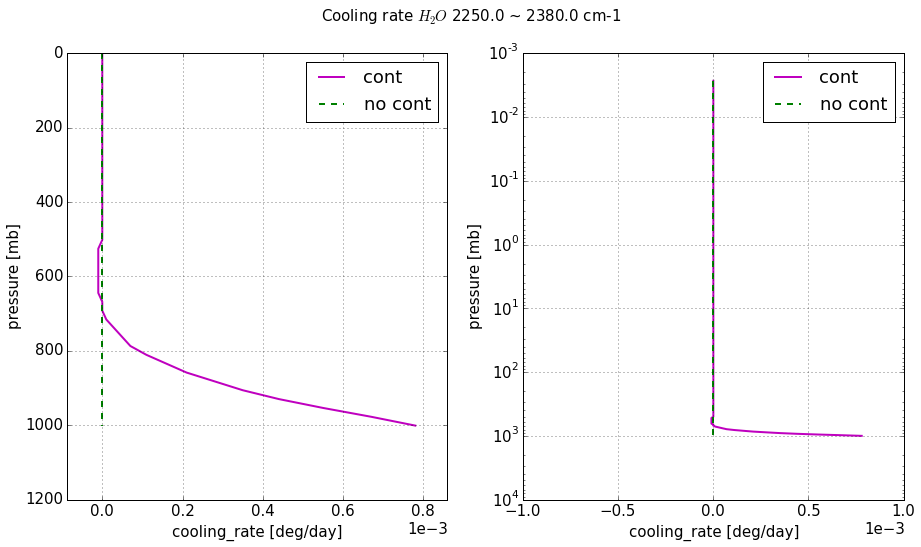

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2380.0 ~ 2600.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.5477     0.0000   -0.5477      -0.00000
30   299.70000  -0.5693     0.0007   -0.5686      -0.00110
0   1013.00000  -0.6658     0.1187   -0.5471       0.00337

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.5487     0.0000   -0.5487      -0.00000
30   299.70000  -0.5702     0.0007   -0.5695      -0.00110
0   1013.00000  -0.6658     0.1142   -0.5516       0.00312

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.0010     0.0000    0.0010       0.00000
30         0   0.0009     0.0000    0.0009       0.00000
0          0   0.0000     0.0045    0.0045       0.00025



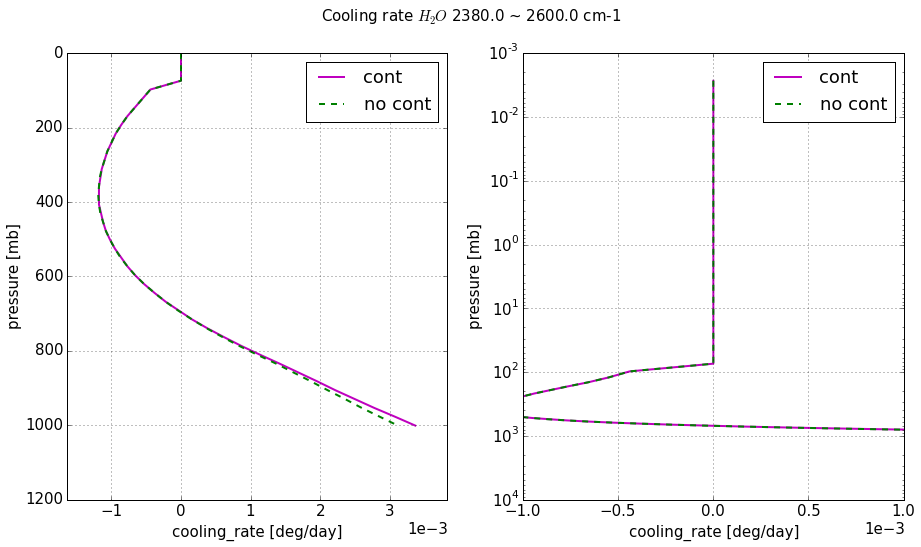

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2600.0 ~ 3250.0 cm-1

cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.3603     0.0000   -0.3603      -0.00000
30   299.70000  -0.3615     0.0002   -0.3613      -0.00014
0   1013.00000  -0.4713     0.1676   -0.3037       0.00367

no cont
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.3668     0.0000   -0.3668      -0.00000
30   299.70000  -0.3679     0.0002   -0.3677      -0.00013
0   1013.00000  -0.4713     0.1516   -0.3197       0.00297

cont - no cont
    pressure  flux_up  flux_down  net_flux  cooling_rate
70         0   0.0065      0.000    0.0065       0.00000
30         0   0.0064      0.000    0.0064      -0.00001
0          0   0.0000      0.016    0.0160       0.00070



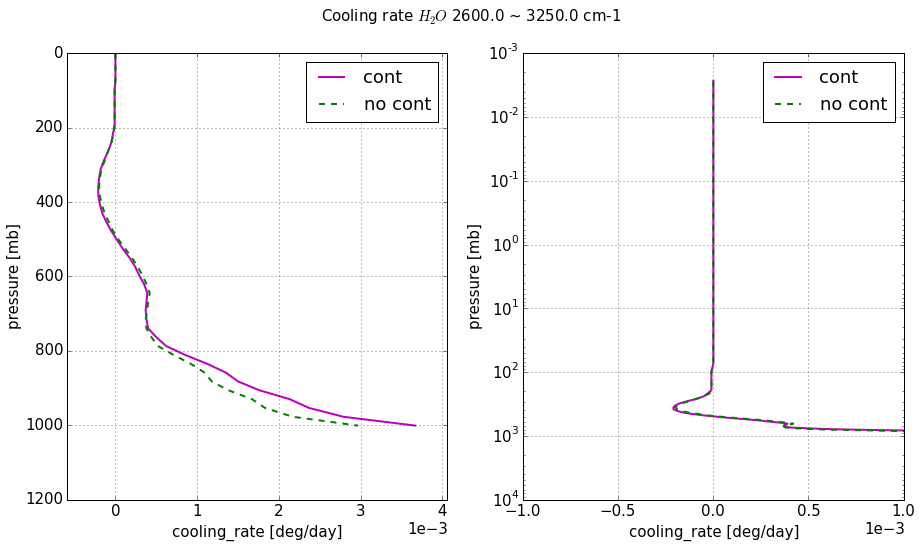

In [22]:
print('Flux tables and cooling rates in RRTMG spectral bands')
print()
print() 

infos_rrtmg = [('cont', 'm', '-', pnl_rrtmg_cont),
               ('no cont', 'g', '--', pnl_rrtmg)]

fluxtableNhrplot_by_rrtmg_bands(infos_rrtmg=infos_rrtmg)

In [23]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')